<a href="https://colab.research.google.com/github/fjadidi2001/AD_Prediction/blob/main/Alzheimer%E2%80%99s_Dementia_Speech.ipynb" target="_parent"><img src="https://colab.research.google.com/assets/colab-badge.svg" alt="Open In Colab"/></a>

In [1]:
!pip install pydub

In [2]:
import os
import tarfile
import glob
import librosa
import numpy as np
import pandas as pd
import matplotlib.pyplot as plt
import seaborn as sns
from scipy.io import wavfile
from pydub import AudioSegment
from pydub.silence import split_on_silence
import soundfile as sf
from sklearn.preprocessing import StandardScaler
import uuid
from pathlib import Path

In [3]:
# Step 1: Load Dataset from Google Drive
from google.colab import drive
drive.mount('/content/drive')

# Define paths to the .tgz files
data_path = '/content/drive/MyDrive/Voice/ADRESS021/'
train_prog_tgz = os.path.join(data_path, 'ADRESS021-progression-train.tgz')
test_prog_tgz = os.path.join(data_path, 'ADRESS021-progression-test.tgz')
train_diag_tgz = os.path.join(data_path, 'ADRESS021-diagnosis-train.tgz')

# Extract .tgz files
extracted_path = '/content/adress021_data/'
os.makedirs(extracted_path, exist_ok=True)

Mounted at /content/drive


In [4]:
import tarfile
import glob
import os

# Define file paths
train_prog_tgz = '/content/drive/MyDrive/Voice/ADReSSo21-progression-train.tgz'
test_prog_tgz = '/content/drive/MyDrive/Voice/ADReSSo21-progression-test.tgz'
train_diag_tgz = '/content/drive/MyDrive/Voice/ADReSSo21-diagnosis-train.tgz'
extracted_path = '/content/extracted_audio'  # Directory to extract files to

# Ensure extracted_path exists
os.makedirs(extracted_path, exist_ok=True)

# Function to extract .tgz files
def extract_tgz(tgz_path, extract_to):
    try:
        with tarfile.open(tgz_path, 'r:gz') as tar:
            tar.extractall(path=extract_to)
        print(f"Successfully extracted {tgz_path} to {extract_to}")
    except FileNotFoundError:
        print(f"Error: File {tgz_path} not found.")
    except Exception as e:
        print(f"Error extracting {tgz_path}: {str(e)}")

# Extract each .tgz file
for tgz in [train_prog_tgz, test_prog_tgz, train_diag_tgz]:
    if os.path.exists(tgz):
        extract_tgz(tgz, extracted_path)
    else:
        print(f"Skipping {tgz}: File does not exist.")

# Find all WAV files
audio_files = glob.glob(os.path.join(extracted_path, '**/*.wav'), recursive=True)
print(f"Found {len(audio_files)} audio files.")

Successfully extracted /content/drive/MyDrive/Voice/ADReSSo21-progression-train.tgz to /content/extracted_audio
Successfully extracted /content/drive/MyDrive/Voice/ADReSSo21-progression-test.tgz to /content/extracted_audio
Successfully extracted /content/drive/MyDrive/Voice/ADReSSo21-diagnosis-train.tgz to /content/extracted_audio
Found 271 audio files.


In [5]:
# Load metadata (assuming there's a CSV or text file with labels)
# Modify this based on actual metadata structure
metadata_path = glob.glob(os.path.join(extracted_path, '**/*.csv'), recursive=True)
if metadata_path:
    metadata = pd.read_csv(metadata_path[0])
    print("Metadata loaded:")
    print(metadata.head())
else:
    metadata = pd.DataFrame({'file': audio_files, 'label': 'unknown'})
    print("No metadata CSV found. Using file paths only.")

Metadata loaded:
   Unnamed: 0 adressfname  mmse  dx
0          23    adrso024    20  ad
1          24    adrso025    11  ad
2          25    adrso027    18  ad
3          26    adrso028    18  ad
4          28    adrso031    26  ad


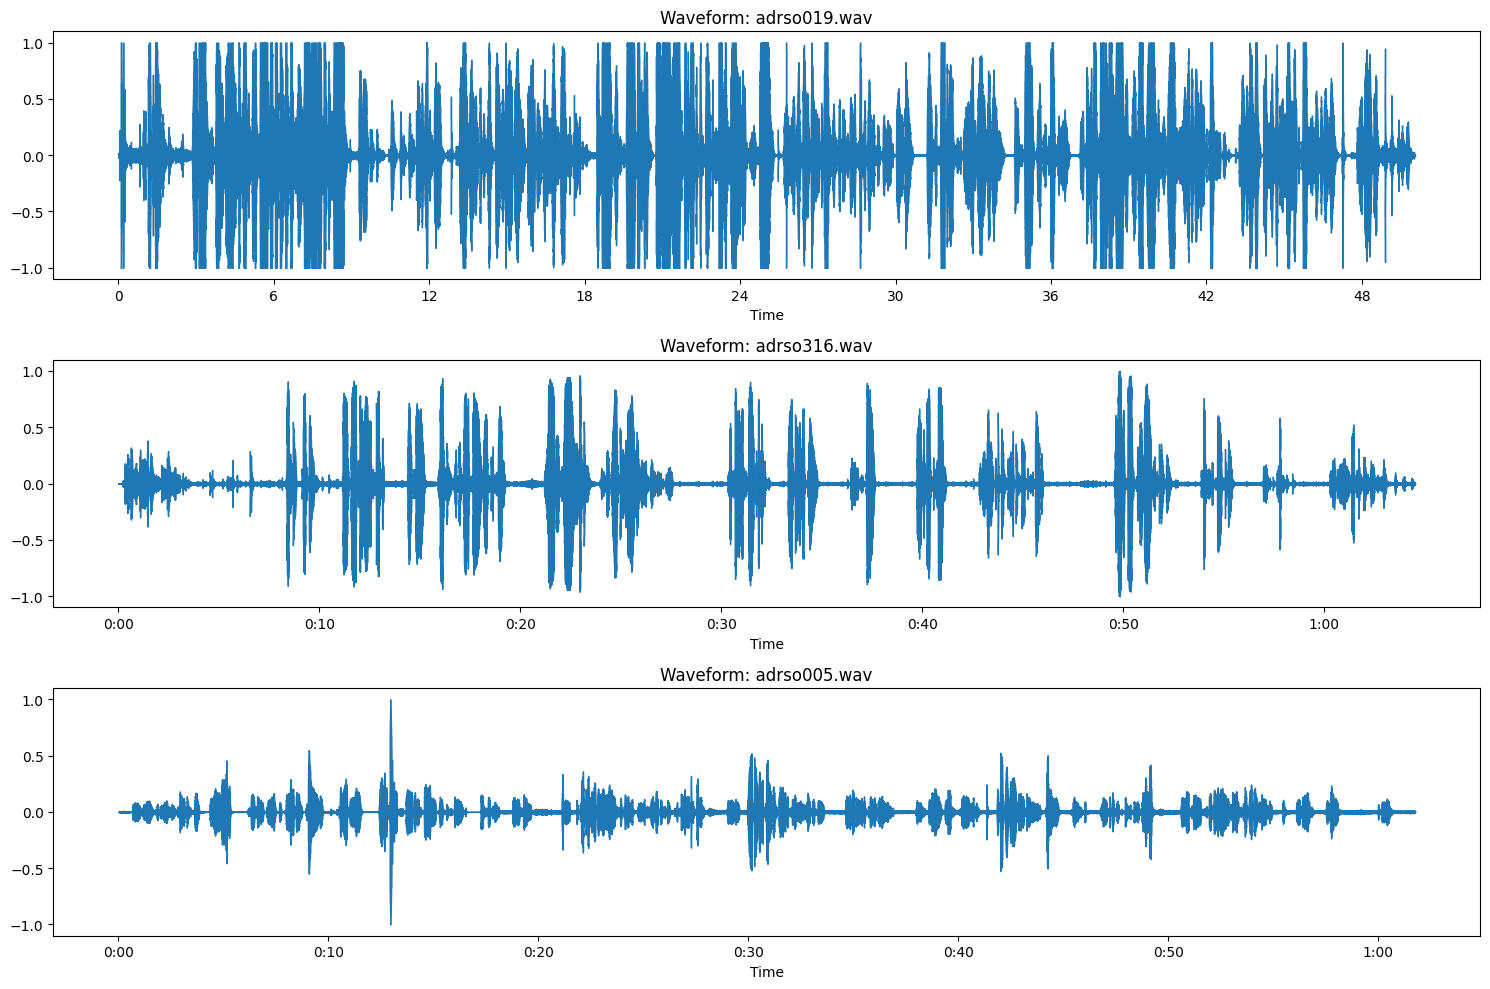


Sample Metadata:
   Unnamed: 0 adressfname  mmse  dx
0          23    adrso024    20  ad
1          24    adrso025    11  ad
2          25    adrso027    18  ad
3          26    adrso028    18  ad
4          28    adrso031    26  ad


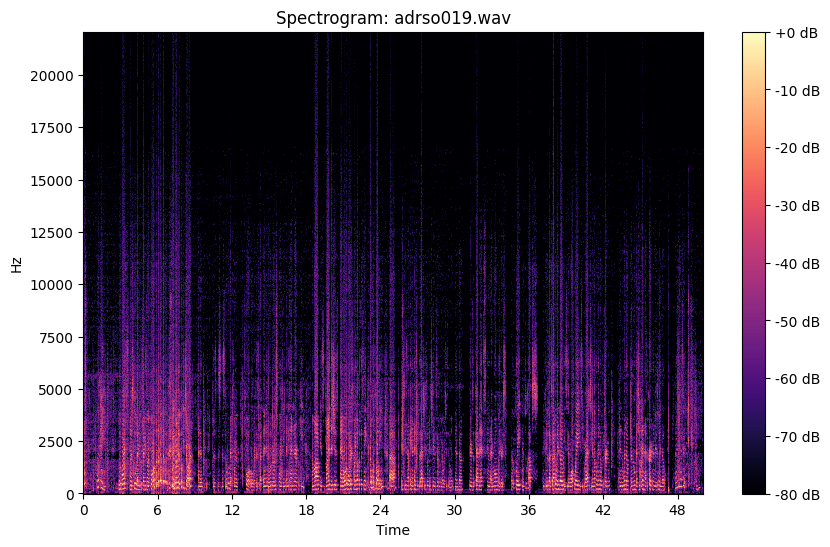

No label column found in metadata.


In [6]:
# Step 2: Visualize and Explore Dataset
# Select a few sample audio files
sample_files = audio_files[:3]

# Visualize waveforms
plt.figure(figsize=(15, 10))
for i, audio_file in enumerate(sample_files):
    y, sr = librosa.load(audio_file, sr=None)
    plt.subplot(len(sample_files), 1, i+1)
    librosa.display.waveshow(y, sr=sr)
    plt.title(f"Waveform: {os.path.basename(audio_file)}")
plt.tight_layout()
plt.savefig('/content/waveforms.png')
plt.show()

# Show sample metadata
print("\nSample Metadata:")
print(metadata.head())

# Plot spectrogram for one sample
y, sr = librosa.load(sample_files[0], sr=None)
D = librosa.amplitude_to_db(np.abs(librosa.stft(y)), ref=np.max)
plt.figure(figsize=(10, 6))
librosa.display.specshow(D, sr=sr, x_axis='time', y_axis='hz')
plt.colorbar(format='%+2.0f dB')
plt.title(f"Spectrogram: {os.path.basename(sample_files[0])}")
plt.savefig('/content/spectrogram.png')
plt.show()

# Show label distribution (assuming metadata has a 'label' column)
if 'label' in metadata.columns:
    plt.figure(figsize=(8, 6))
    sns.countplot(data=metadata, x='label')
    plt.title('Label Distribution')
    plt.savefig('/content/label_distribution.png')
    plt.show()
else:
    print("No label column found in metadata.")

In [ ]:
# Step 3: Preprocess Dataset
processed_features = []
output_dir = '/content/processed_features/'
os.makedirs(output_dir, exist_ok=True)

for audio_file in audio_files:
    # Load audio
    y, sr = librosa.load(audio_file, sr=16000, mono=True)  # Standardize to 16kHz, mono

    # Noise Removal (simple spectral gating)
    y_denoised = librosa.decompose.nn_filter(y, aggregate=np.median, metric='cosine')

    # Silence Trimming
    y_trimmed, _ = librosa.effects.trim(y_denoised, top_db=20)

    # Segmentation (Optional)
    audio = AudioSegment.from_wav(audio_file)
    chunks = split_on_silence(audio, min_silence_len=500, silence_thresh=-40)
    segments = []
    for chunk in chunks:
        chunk.export(f"/content/temp_{uuid.uuid4()}.wav", format="wav")
        seg_y, seg_sr = librosa.load(f"/content/temp_{uuid.uuid4()}.wav", sr=16000)
        segments.append(seg_y)
    if not segments:
        segments = [y_trimmed]  # Use trimmed audio if no segments

    # Feature Extraction
    for seg_y in segments:
        # Acoustic Features (MFCCs)
        mfccs = librosa.feature.mfcc(y=seg_y, sr=16000, n_mfcc=13)
        mfccs_mean = np.mean(mfccs, axis=1)

        # Prosodic Features (Pitch, Energy)
        pitches, magnitudes = librosa.piptrack(y=seg_y, sr=16000)
        pitch_mean = np.mean(pitches[pitches > 0]) if np.any(pitches > 0) else 0
        energy = np.mean(librosa.feature.rms(y=seg_y))

        # Linguistic Features (Placeholder: requires transcription)
        # Example: word count, pause frequency (needs external ASR)
        linguistic_features = np.array([0, 0])  # Placeholder

        # Combine features
        features = np.concatenate([mfccs_mean, [pitch_mean, energy], linguistic_features])
        processed_features.append(features)

    # Save processed audio (optional)
    sf.write(os.path.join(output_dir, os.path.basename(audio_file)), y_trimmed, 16000)

# Feature Normalization
scaler = StandardScaler()
processed_features = np.array(processed_features)
normalized_features = scaler.fit_transform(processed_features)

# Data Augmentation (e.g., add noise)
augmented_features = []
for features in normalized_features:
    noise = np.random.normal(0, 0.01, features.shape)
    augmented_features.append(features + noise)
augmented_features = np.array(augmented_features)

# Export Processed Features
np.save(os.path.join(output_dir, 'normalized_features.npy'), normalized_features)
np.save(os.path.join(output_dir, 'augmented_features.npy'), augmented_features)
print(f"Processed features saved to {output_dir}")

# Clean up temporary files
for temp_file in glob.glob('/content/temp_*.wav'):
    os.remove(temp_file)